The following code is adapted from http://www.sagargv.com/blog/meta-learning-in-pytorch/ and illustrates how to use pytorch to differentiate through an unrolled iterative optimization a common technique in "meta-learning".  

Specifically consider $f_s$ which will define a randomly sampled sinusoid with a different frequency. We want to have a function $f_{w}(x)$ that fits the sinusoid using just 4 samples of $(x, f_s(x))$ and a few iterations of gradient descent. 

To do this we will formulate the problem as finding a good initialization $w_0$ to rapidly obtain the best fit, which also generalizes to the unseen points. Assume we have some way to sample various sinusoid to learn this intiliazation and we split these samples for each one into $(X_{train}, f_s(X_{train}))$ and a validation set $(X_{val}, f_s(X_{val}))$


We now solve the following nested optimzation 

$\min_{w_0}\mathcal{L}(f_{w_T}(X_{val}),f_t(X_{val}))$
where $w_T$ is obtained by iterating $T$ times
$w_{t} = w_{t-1} -\alpha\nabla \mathcal{L}(f_{w_{t-1}}(X_{train}),f_s(X_{train}))$. 


Observe that to take a gradient descent step on this objective we must differentiate through the $T$ gradient steps of the inner problem, including the gradient operation! Fortunately pytorch is able to do this in almost the same way we are used to. Your take away from this lab should be that we can differentiate through multiple iterations of gradient descent allowing us to construct these kind of nested objective functions.

Run the code cell below and try to get an understanding of what it is doing

In [1]:
# From http://www.sagargv.com/blog/meta-learning-in-pytorch/

import math
import random
import torch 
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

def net(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.tanh(x)

    x = F.linear(x, params[2], params[3])
    x = F.tanh(x)

    x = F.linear(x, params[4], params[5])
    return x

params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

opt = torch.optim.SGD(params, lr=1e-2)
n_inner_loop = 3
alpha = 3e-2

for it in range(5000):
    # sample frequency 
    a = torch.rand(1).item()*0.5+0.5
    
    #Data for the inner loop
    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(a*x)

    #Data for the outer loop
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(a*v_x)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f = net(x, new_params)
        loss = F.l1_loss(f, y)

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 500 == 0: print('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, loss))

    v_f = net(v_x, new_params)
    loss2 = F.l1_loss(v_f, v_y)
    loss2.backward()

    opt.step()

    if it % 500 == 0: print('Iteration %d -- Outer Loss: %.4f' % (it, loss2))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration 0 -- Inner loop 0 -- Loss: 0.5677
Iteration 0 -- Inner loop 1 -- Loss: 0.5127
Iteration 0 -- Inner loop 2 -- Loss: 0.4579
Iteration 0 -- Outer Loss: 0.6380
Iteration 500 -- Inner loop 0 -- Loss: 0.8761
Iteration 500 -- Inner loop 1 -- Loss: 0.4141
Iteration 500 -- Inner loop 2 -- Loss: 0.1089
Iteration 500 -- Outer Loss: 0.2063
Iteration 1000 -- Inner loop 0 -- Loss: 0.2679
Iteration 1000 -- Inner loop 1 -- Loss: 0.1904
Iteration 1000 -- Inner loop 2 -- Loss: 0.2458
Iteration 1000 -- Outer Loss: 0.2600
Iteration 1500 -- Inner loop 0 -- Loss: 0.1043
Iteration 1500 -- Inner loop 1 -- Loss: 0.0618
Iteration 1500 -- Inner loop 2 -- Loss: 0.0338
Iteration 1500 -- Outer Loss: 0.3144
Iteration 2000 -- Inner loop 0 -- Loss: 0.3098
Iteration 2000 -- Inner loop 1 -- Loss: 0.1406
Iteration 2000 -- Inner loop 2 -- Loss: 0.0990
Iteration 2000 -- Outer Loss: 0.0918
Iteration 2500 -- Inner loop 0 -- Loss: 0.6753
Iteration 2500 -- Inner loop 1 -- Loss: 0.4958
Iteration 2500 -- Inner loop 2 -

1) We can now "evaluate"  the initialization we learned. Run the cell below a few times to get an idea of how well it fits a new sinusoid. You don't need to add any new code here.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


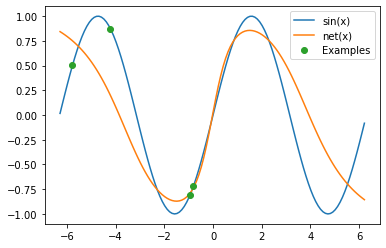

In [83]:
t_b = 0 #math.pi
a = torch.rand(1).item()*0.5+0.5
t_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
# print(t_x)
t_y = torch.sin(a*t_x + t_b)
# print(t_y)
opt.zero_grad()
t_params = params
for k in range(n_inner_loop):
    t_f = net(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)
    # print(t_loss)
    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.1).unsqueeze(1)
test_y = torch.sin(a*test_x + t_b)

test_f = net(test_x, t_params)
# print(test_f)
plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.show()

We are going to try to understand what the above code does.

2) Modify the above evaluation cell to set t_b = math.pi. Qualitatively how does the solution compare to t_b = 0. Explain the behavior. 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


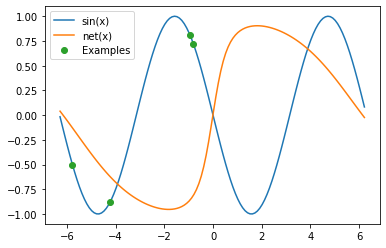

In [84]:
t_b = math.pi #math.pi
t_y = torch.sin(a*t_x + t_b)

opt.zero_grad()

t_params = params
for k in range(n_inner_loop):
    t_f = net(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)

    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]



test_y = torch.sin(a*test_x + t_b)
test_f = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.show()

**It's really bad , the predicted sin wave looks like shifted by and flatten**

3) Rerun the cell from (1) and then write a code to compare the result on the same sinusoid to just initializing the network with a random $w_0$ instead of one learnt with the nested objective.  Fit the same function with the same number of steps (n_inner_loop).  

In [88]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.tanh(x)

    x = F.linear(x, params[2], params[3])
    x = F.tanh(x)

    x = F.linear(x, params[4], params[5])
    return x

params = [
    # torch.Tensor(32, 1).rand().requires_grad_(),
    torch.rand(32, 1).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

opt = torch.optim.SGD(params, lr=1e-2)
n_inner_loop = 3
alpha = 3e-2

for it in range(5000):
    # # sample frequency 
    # a = torch.rand(1).item()*0.5+0.5
    
    # #Data for the inner loop
    # x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    # y = torch.sin(a*x)

    # #Data for the outer loop
    # v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    # v_y = torch.sin(a*v_x)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f = net(x, new_params)
        loss = F.l1_loss(f, y)

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 500 == 0: print('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, loss))

    v_f = net(v_x, new_params)
    loss2 = F.l1_loss(v_f, v_y)
    loss2.backward()

    opt.step()

    if it % 500 == 0: print('Iteration %d -- Outer Loss: %.4f' % (it, loss2))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration 0 -- Inner loop 0 -- Loss: 0.5309
Iteration 0 -- Inner loop 1 -- Loss: 0.5176
Iteration 0 -- Inner loop 2 -- Loss: 0.5042
Iteration 0 -- Outer Loss: 0.9492
Iteration 500 -- Inner loop 0 -- Loss: 2.8151
Iteration 500 -- Inner loop 1 -- Loss: 2.0769
Iteration 500 -- Inner loop 2 -- Loss: 1.3137
Iteration 500 -- Outer Loss: 0.2826
Iteration 1000 -- Inner loop 0 -- Loss: 2.4529
Iteration 1000 -- Inner loop 1 -- Loss: 1.7242
Iteration 1000 -- Inner loop 2 -- Loss: 1.0397
Iteration 1000 -- Outer Loss: 0.1562
Iteration 1500 -- Inner loop 0 -- Loss: 2.1900
Iteration 1500 -- Inner loop 1 -- Loss: 1.5213
Iteration 1500 -- Inner loop 2 -- Loss: 0.9341
Iteration 1500 -- Outer Loss: 0.0898
Iteration 2000 -- Inner loop 0 -- Loss: 1.9486
Iteration 2000 -- Inner loop 1 -- Loss: 1.2906
Iteration 2000 -- Inner loop 2 -- Loss: 0.7262
Iteration 2000 -- Outer Loss: 0.1189
Iteration 2500 -- Inner loop 0 -- Loss: 2.0215
Iteration 2500 -- Inner loop 1 -- Loss: 1.4217
Iteration 2500 -- Inner loop 2 -

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


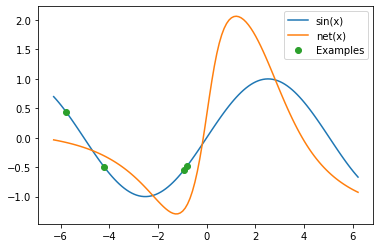

In [89]:
t_b = 0 #math.pi
a = torch.rand(1).item()*0.5+0.5
t_y = torch.sin(a*t_x + t_b)
# print(t_y)
opt.zero_grad()
t_params = params
for k in range(n_inner_loop):
    t_f = net(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)
    # print(t_loss)
    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

test_y = torch.sin(a*test_x + t_b)

test_f = net(test_x, t_params)
# print(test_f)
plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.show()

4) Now let's imagine we also want to find the best learning rate to use in the inner loop using gradient descent. We can now add the learning rate as a parameter to optimize in the outer objective. Thus we have

$\min_{w,\alpha}\mathcal{L}(f_{w_T}(X_{val}),f_t(X_{val}))$
where $w$ is obtained by iterating $T$ times
$w_{t} = w_{t-1} -\alpha\nabla \mathcal{L}(f_{w_{t-1}}(X_{train}),f_s(X_{train}))$. Note $w_T$ is dependent on $w_0$ and $\alpha$.

The code below implements this idea. Modify it to print the gradient of $\alpha$ in the first iteration of the outer loop and run the code. 

In [96]:
# From http://www.sagargv.com/blog/meta-learning-in-pytorch/

import math
import random
import torch 
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

def net(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.tanh(x)

    x = F.linear(x, params[2], params[3])
    x = F.tanh(x)

    x = F.linear(x, params[4], params[5])
    return x

params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

alpha = torch.FloatTensor([0.1]).requires_grad_()

opt = torch.optim.SGD(params, lr=1e-2) 
opt2 = torch.optim.Adam([alpha], lr=1e-4)   
n_inner_loop = 5

for it in range(5000):
    # sample frequency 
    a = torch.rand(1).item()*0.5+0.5
    
    #Data for the inner loop
    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(a*x)

    #Data for the outer loop
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(a*v_x)

    opt.zero_grad()
    opt2.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f = net(x, new_params)
        loss = F.l1_loss(f, y)

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 500 == 0: print('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, loss))

    v_f = net(v_x, new_params)
    loss2 = F.l1_loss(v_f, v_y)
    loss2.backward()

    #TODO print the gradient of alpha

    opt.step()
    opt2.step()

    if it % 500 == 0: 
      print('Iteration %d -- Outer Loss: %.4f, learning rate: %.5f' % (it, loss2, alpha))
      print("alpha grad=",alpha.grad)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration 0 -- Inner loop 0 -- Loss: 0.6593
Iteration 0 -- Inner loop 1 -- Loss: 0.2968
Iteration 0 -- Inner loop 2 -- Loss: 0.6132
Iteration 0 -- Inner loop 3 -- Loss: 0.1980
Iteration 0 -- Inner loop 4 -- Loss: 0.1523
Iteration 0 -- Outer Loss: 0.4925, learning rate: 0.09990
alpha grad= tensor([1.6356])
Iteration 500 -- Inner loop 0 -- Loss: 0.5684
Iteration 500 -- Inner loop 1 -- Loss: 0.5506
Iteration 500 -- Inner loop 2 -- Loss: 0.5305
Iteration 500 -- Inner loop 3 -- Loss: 0.5082
Iteration 500 -- Inner loop 4 -- Loss: 0.4832
Iteration 500 -- Outer Loss: 0.6964, learning rate: 0.08678
alpha grad= tensor([-0.7778])
Iteration 1000 -- Inner loop 0 -- Loss: 0.1057
Iteration 1000 -- Inner loop 1 -- Loss: 0.0918
Iteration 1000 -- Inner loop 2 -- Loss: 0.1059
Iteration 1000 -- Inner loop 3 -- Loss: 0.0912
Iteration 1000 -- Inner loop 4 -- Loss: 0.1060
Iteration 1000 -- Outer Loss: 0.2944, learning rate: 0.07558
alpha grad= tensor([0.3883])
Iteration 1500 -- Inner loop 0 -- Loss: 0.4531
I

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


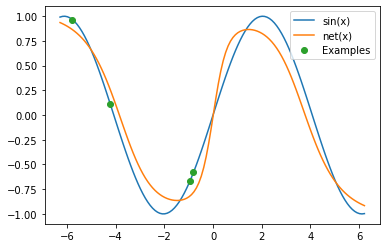

In [97]:
t_b = 0 #math.pi
a = torch.rand(1).item()*0.5+0.5
t_y = torch.sin(a*t_x + t_b)
# print(t_y)
opt.zero_grad()
t_params = params
for k in range(n_inner_loop):
    t_f = net(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)
    # print(t_loss)
    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

test_y = torch.sin(a*test_x + t_b)

test_f = net(test_x, t_params)
# print(test_f)
plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.show()

**Apparently, this is the highest fit**